In [1]:
using Plots, LaTeXStrings
using OrdinaryDiffEq
using OpenQuantumTools, QuadGK

## Set up

We solve the dynamics of a Landau Zener experiment for a single qubit system with the Hamiltonian

$$H_\mathrm{S}=\epsilon(t) \sigma_z + \Delta \sigma_x$$

coupled to some bath operator $B$ via $\sigma_z$ interaction:

$$H = H_\mathrm{S} + \sigma_z \otimes B + H_\mathrm{B}\ .$$ 

Here we consider the finite time Landau-Zener experiment. Without loss of generality, we assume the function is linearly in dimensionless time $s=t/t_f$

$$\epsilon(s) = 2*s - 1 \ .$$


In [2]:
Δ = 0.1
H = DenseHamiltonian([(s)->2*s-1, (s)->1.0], [σz, Δ * σx], unit=:ħ)

DenseHamiltonian with Complex{Float64}
with size: (2, 2)

The gap structure of the problem is

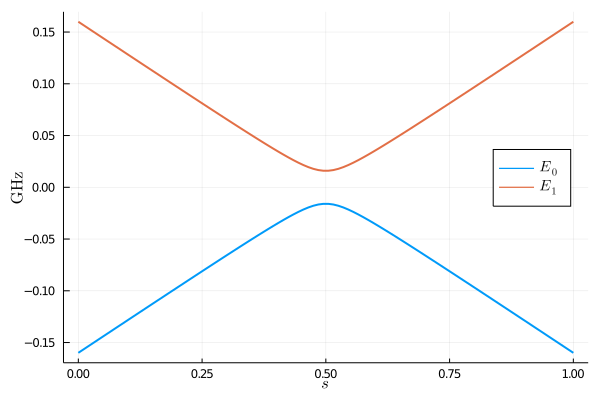

In [3]:
plot(H, range(0,1,length=100), 2, legend=:right, linewidth=2, legendfont=10)

## Closed system simulation

We start in the ground state of the Hamiltonian $|0\rangle$

In [4]:
u0 = PauliVec[3][1]

2-element Array{Complex{Float64},1}:
 1.0 + 0.0im
 0.0 + 0.0im

In [5]:
annealing = Annealing(H, u0)

Annealing with DenseHamiltonian{Complex{Float64}} and u0 Array{Complex{Float64},1}
u0 size: (2,)

In [6]:
tf_list = range(10, 200, length=200)
res = []
for tf in tf_list
    sol = solve_schrodinger(annealing, tf, alg = Tsit5(), save_everystep=false, reltol=1e-6, abstol=1e-6)
    push!(res, abs2(sol[end][1]))
end

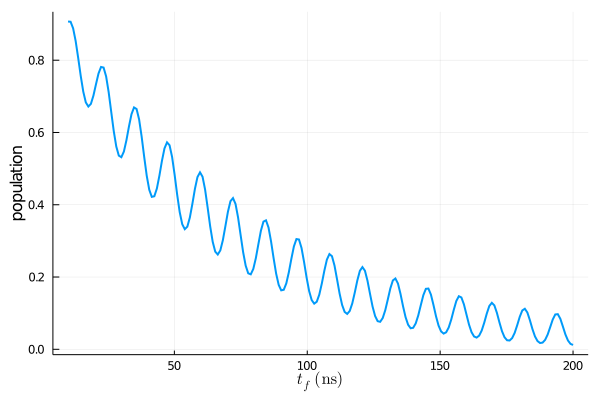

ERROR: syntax error


In [7]:
plot(tf_list, res, linewidth=2, xlabel=L"t_f \ (\mathrm{ns})", ylabel="population", label=L"|0\rangle")

## Adiabatic master equation with custom noise spectrum

First we define a function which build a custom 1/f noise spectrum function from the following parameters: amplitude $\alpha$, low cut off frequency $\omega_l$, high cut off frequency $\omega_h$ and temperature $\beta$. The form of the noise spectrum is

$$ S(\omega) =     \begin{cases}
      \frac{\alpha}{\omega} & \omega_l <\omega \leq \omega_h \\
      \frac{\alpha}{\omega_l} & 0 <\omega \leq \omega_l \\
      \frac{e^{\beta\omega}\alpha}{\omega_l} & -\omega_l <\omega \leq 0 \\
      -\frac{e^{\beta\omega}\alpha}{\omega} & -\omega_h <\omega \leq -\omega_l\\
      0 & \text{otherwise}
    \end{cases}   \ ,$$
where $\omega$ in the above notation means the angular frequency.


In [8]:
function build_custom_1f_spectrum(amplitude, low_cut_off, high_cut_off, temperature, α)
    β = temperature_2_β(temperature)
    function spectrum(ω)
        if ω>high_cut_off
            0
        elseif ω>low_cut_off
            amplitude / ω^α
        elseif ω>0
            amplitude / low_cut_off^α
        elseif ω>-low_cut_off
            exp(β*ω) * amplitude / low_cut_off^α
        elseif ω>-high_cut_off
            -exp(β*ω) * amplitude / ω^α
        else
            0
        end
    end
end;

In [9]:
amp = 1e-3
fl = 1e-4
fh = 1
T = 12
α = 0.91

Sf = build_custom_1f_spectrum(amp, 2*π*fl, 2*π*fh, T, α);

Here we plot the noise spectrum of this customized function

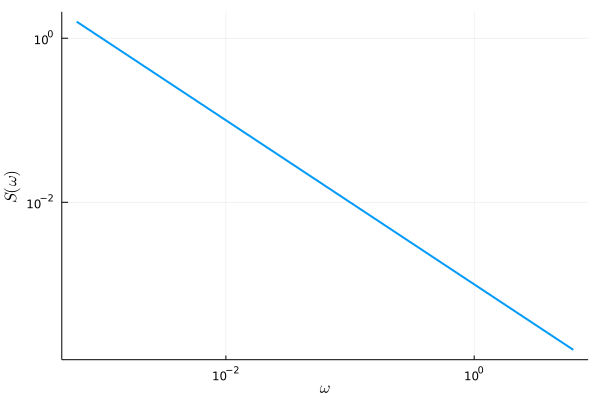

In [10]:
w_axis = 2*π*range(1e-4, 1, length=200)
plot(w_axis, Sf.(w_axis),xscale=:log10, yscale=:log10, xlabel=L"\omega", ylabel=L"S(\omega)", label="", linewidth=2)

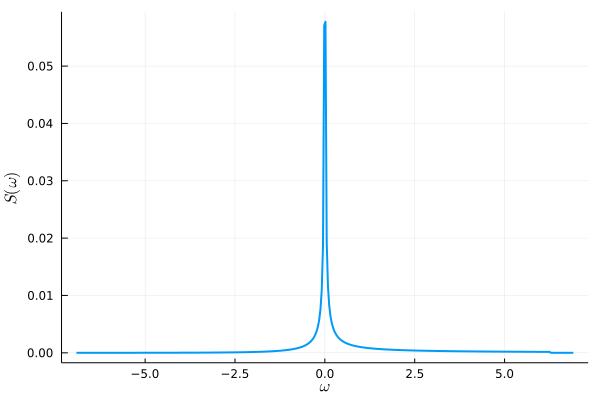

In [11]:
w_axis = 2*π*range(-1.1, 1.1, length=400)
plot(w_axis, Sf.(w_axis), xlabel=L"\omega", ylabel=L"S(\omega)", label="", linewidth=2)

Now, we will combine this noise spectrum together with the Ohmic spectrum.

In [12]:
η=1e-4; fc=2*π*4; T=12;
ohmic_bath = Ohmic(η, fc, T)

Ohmic bath instance:
η (unitless): 0.0001
ωc (GHz): 25.132741228718345
T (mK): 12.0

In [13]:
function combine_spectrum(ohmic_object, Sf)
    (ω) -> spectrum(ω, ohmic_object) + Sf(ω)
end
combined_spectrum = combine_spectrum(ohmic_bath, Sf);

The combined noise spectrum is

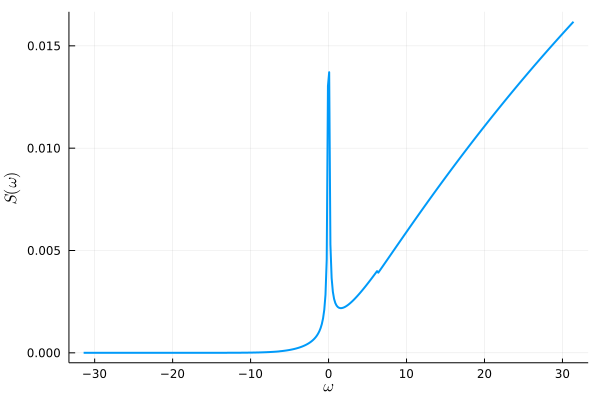

In [14]:
w_axis = 2*π*range(-5, 5, length=400)
plot(w_axis, combined_spectrum.(w_axis), xlabel=L"\omega", ylabel=L"S(\omega)", label="", linewidth=2)

Now we solve the adiabatic master equation using the combined noise spectrum.

In [15]:
coupling = ConstantCouplings(["Z"], unit=:ħ)
bath = CustomBath(spectrum=combined_spectrum);

In [16]:
annealing = Annealing(H, u0, coupling=coupling, bath=bath)

Annealing with DenseHamiltonian{ComplexF64} and u0 Vector{ComplexF64}
u0 size: (2,)

### Solve the "1/f" adiabatic master equation

In the following code block, we solve the dynamics of the AME with "1/f" noise spectrum. We plot the $| 0 \rangle$ population w.r.t. to different total evolution time $t_f$.

In [17]:
tf_list = range(10, 200, length=200)
res = []
for tf in tf_list
    sol = solve_ame(annealing, tf, alg=Tsit5(), ω_hint=range(-2,2,length=100), abstol=1e-6, reltol=1e-6)
    push!(res, real(sol[end][1,1]))
end

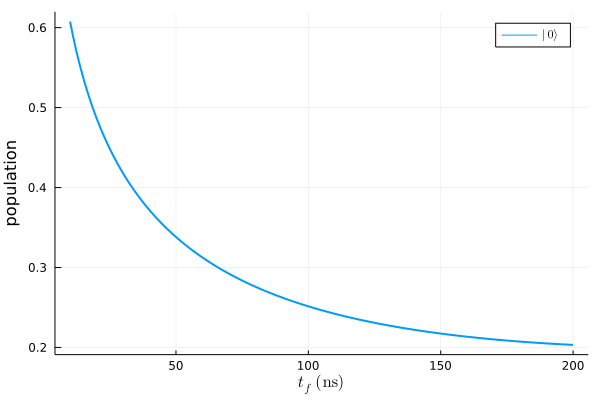

In [18]:
plot(tf_list, res, linewidth=2, xlabel=L"t_f \ (\mathrm{ns})", ylabel="population", label=L"|0\rangle")

## Hybridization AME with fluctuators

In this section, we hybridize the above AME model with spin fluctuators. We define the parameters for the stochastic process
\begin{equation}
    S(\omega) = \sum_{i=1}^{N} \frac{2b_i^2\gamma_i}{\gamma_i^2 + \omega^2} \ ,
\end{equation}
where, for simiplicity, we fix $N=10$, $b_i=b$ and choose $\gamma_i$s log uniformly between $\gamma_{min}$ and $\gamma_{max}$.

In [19]:
# here the units for γmin and γmax are GHz
b = 1e-4; γmin=1e-4; γmax=1; num=10;

log_start = log10(γmin)
log_stop = log10(γmax)
γvec = 10 .^ (range(log_start, log_stop, length = num))

fluctuator_bath = EnsembleFluctuator(b .* ones(num), γvec);

We plot the noise spectrum generated by the fluctuator ensemble within $\gamma_{min}$ and $\gamma_{max}$.

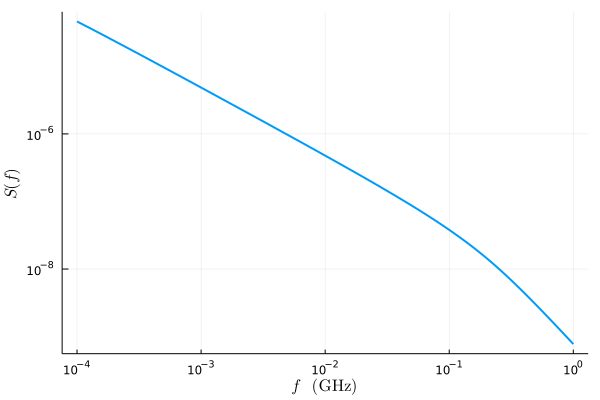

In [20]:
f_start = log10(1e-4)
f_stop = log10(1)
f_list = 10 .^ (range(f_start, f_stop, length = 1000))
slist = [spectrum(2*π*f, fluctuator_bath) for f in f_list];

plot(f_list, slist, xscale=:log10, yscale=:log10, xlabel=L"f\quad (\mathrm{GHz})", 
    ylabel=L"S(f)", label="", linewidth=2)

Finally, we combine fluctuator model with the custom noise object defined in the previous section.

In [21]:
interaction_fluctuator = Interaction(coupling, fluctuator_bath)
interaction_custom = Interaction(coupling, bath)
interactions = InteractionSet(interaction_fluctuator, interaction_custom)

InteractionSet with 2 interactions

Here for illustration purpose, we only solve the dynamics for $t_f = 100 (\mathrm{ns})$ with two trajectories.

In [22]:
annealing = Annealing(H, u0, interactions = interactions)
tf = 100
prob = build_ensembles(annealing,tf,:ame,ω_hint = range(-2,2,length=100))

EnsembleProblem with problem ODEProblem

In [23]:
# To solve this in parallel, we need to replace 'EnsembleSerial()' with 'EnsembleDistributed()' and excute julia with argument -p
# for example julia -p 8 script.jl will execute the script.jl using 8 processes.
sol = solve(prob, Tsit5(), EnsembleSerial(), trajectories=2, reltol=1e-6);

Each element in the `sol` object contain a single trajectory. In the following code block, we plot the population of $|0\rangle$ state along one trajectory.

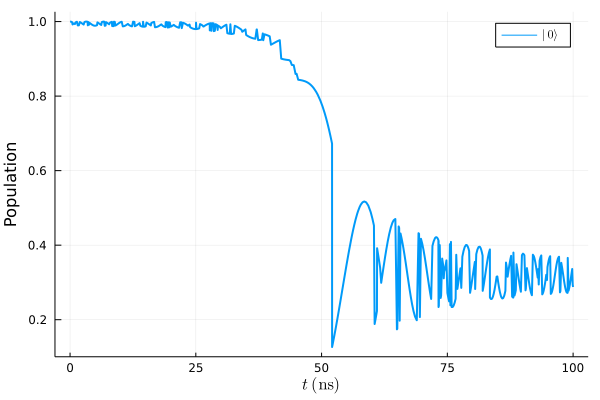

In [24]:
plot(sol[1].t, [abs2(normalize(x)[1]) for x in sol[1].u], xlabel=L"t\ (\mathrm{ns})", ylabel="Population", label=L"|0\rangle", linewidth=2)

In [28]:
# Here are some useful keyword arguments to help speed up the solver
# `save_positions=(false,false)` and `save_everystep=false` will stop the solver from saving the intermediate results
# `maxiters` is the maximum iterations allowed for the solver, the default value is 1e5
sol_alt = solve(prob, Tsit5(), EnsembleSerial(), trajectories=2, reltol=1e-6, 
    save_positions=(false,false), save_everystep=false, maxiters=1e7);

In [29]:
# if we look at the new solution object, we can see that there are no intermediate results in it
sol_alt[1]

retcode: Success
Interpolation: 1st order linear
t: 2-element Vector{Float64}:
   0.0
 100.0
u: 2-element Vector{Vector{ComplexF64}}:
 [1.0 + 0.0im, 0.0 + 0.0im]
 [-0.10085094368543082 + 0.4310751370593276im, -0.5487946418176723 - 0.03367501458582824im]

The true dynamics needs to be averaged over the entire ensemble.

## Polaron transformed Redfield equation

In this example, we solve the Landau-Zener problem using the polaron transformed Redfield equation. To do this, we first define the Hamiltonian in the polaron frame

$$ H = \epsilon(t)\sigma_z \ .$$

In [8]:
Δ = 0.1
H = DenseHamiltonian([(s)->2*s-1], [σz], unit=:ħ)

DenseHamiltonian with Complex{Float64}
with size: (2, 2)

The polaron frame system-bath coupling operators are $\sigma_+$ and $\sigma_-$ operators multiplied by the tunneling amplitude $\Delta$.

In [9]:
u0 = PauliVec[3][1]
coupling = ConstantCouplings(Δ*[σ₊, σ₋], unit=:ħ)

ConstantCouplings with Complex{Float64}
and string representation: nothing

Then we define a hybrid Ohmic bath using `CustomBath`. This is a bath object consisting of low-frequency and high-frequency components. The low-frequency component is characerized by the MRT linewidth $W$ and the high-frequency component is the standard Ohmic bath. The spectrum of this bath is

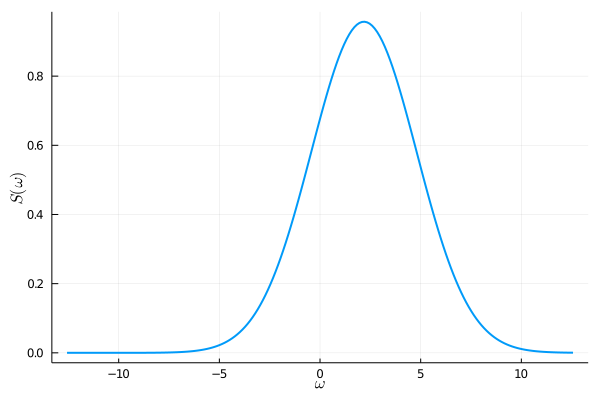

In [17]:
# The unit of the MRT linewidth is mK
W=10; η=1e-5; fc=2*π*4; T=12
ω_list = 2 * π * range(-2, 2, length=200)
bath = HybridOhmic(W, η, fc, T)
y = [spectrum(w, bath) for w in ω_list]
plot(ω_list, y, linewidth=2, xlabel=L"\omega", label="", ylabel=L"S(\omega)")

In [18]:
sfun = construct_interpolations(ω_list, y)
bath = CustomBath(spectrum=sfun)
anneal = Annealing(H, u0, coupling=coupling, bath=bath)

Annealing with DenseHamiltonian{Complex{Float64}} and u0 Array{Complex{Float64},1}
u0 size: (2,)

Now we can solve the Lindblad form PTRE using the following code:

In [19]:
tf_list = range(10, 1000, length=51)
res = []
for tf in tf_list
    sol = solve_ame(anneal, tf, lambshift=false, alg=Tsit5(), reltol=1e-6, abstol=1e-6, save_everystep=false)
    push!(res, real(sol[end][1,1]))
end

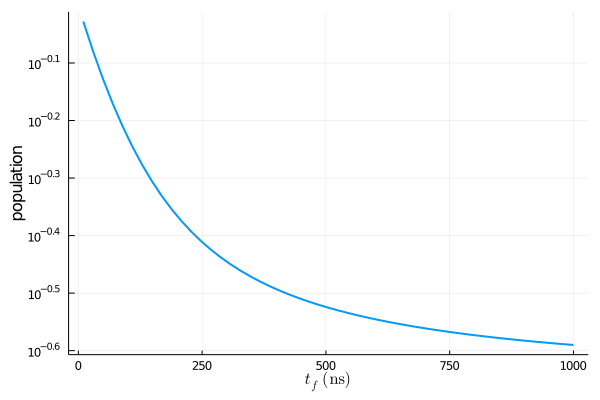

ERROR: syntax error


In [20]:
plot(tf_list, res, yscale=:log10, linewidth=2, xlabel=L"t_f \ (\mathrm{ns})", ylabel="population", label=L"|0\rangle")

## Adding high frequency 1/f spectrum into polaron transformed Redfield equation

Let's first revisit the customized high frequency 1/f noise. It can be constructed by specifying an amplitude $\alpha$, a low-frequency cutoff $f_l$, a high frequency cutoff $f_h$ and a temperature $T$.

In [31]:
α = 1e-3
fl = 1e-4
fh = 1
T = 12

Sf = build_custom_1f_spectrum(α, 2*π*fl, 2*π*fh, T)

(::var"#spectrum#5"{Float64, Float64, Float64, Float64}) (generic function with 1 method)

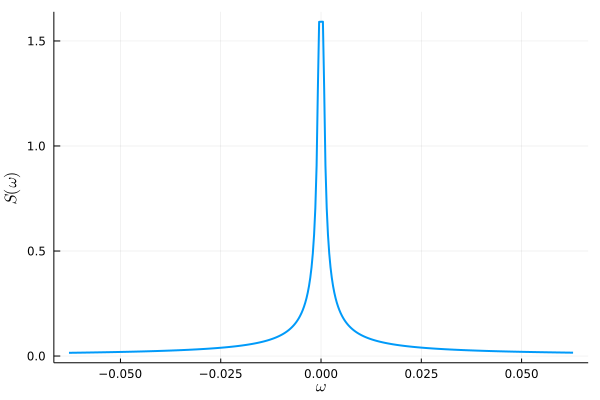

In [32]:
w_axis = 2*π*range(-0.01, 0.01, length=400)
plot(w_axis, Sf.(w_axis), xlabel=L"\omega", ylabel=L"S(\omega)", label="", linewidth=2)

The polaron frame spectrum is defined by
\begin{align}
    \gamma_K(\omega) &= \int_{-\infty}^{\infty} e^{4(f_L(t)+f_H(t))}e^{i\omega t}dt \\
    &= \frac{1}{2\pi}\int dx G_L(\omega-x)G_H(x)dx \ ,
\end{align}
where $G_L(\omega)$ and $G_H(\omega)$ are Fourier transfoms of $e^{4f_L(t)}$ and $e^{4f_H(t)}$ respectively. 



Our goal is to add a high-frequency $1/f$ component into $f_H(t)$. The definition of $f_H(t)$ is given by
\begin{equation}
    f_H(t) = \int_{-\infty}^{\infty} \gamma_{H}(\omega) \frac{e^{-i \omega t}-1}{\omega^{2}} d\omega \ .
\end{equation}

We know the Fourier transform of $\exp\{4f_H(t)\}$ can be approximated by
$$
    G_H(\omega) = \frac{4 \gamma_{\mathrm{H}}(\omega)}{\omega^{2}+4 \gamma_{\mathrm{H}}(0)^{2}} \ .
$$
So we can directly add the customized high-frequency Ohmic bath into $\gamma_H(\omega)$. The is done in the following two code blocks:

In [42]:
function build_polaron_high_freq_1f_spectrum(W, η, fc, T, high_freq_1f_S)
    bath = HybridOhmic(W, η, fc, T)
    Gl(ω) = OpenQuantumTools.OpenQuantumBase.Gₗ(ω, bath)
    function Gh(ω)
        η = bath.η
        S0 = η / bath.β + high_freq_1f_S(0)
        if isapprox(ω, 0, atol=1e-8)
            1 / S0
        else
            (4 * (η * ω * exp(-abs(ω) / bath.ωc) / (1 - exp(-bath.β * ω)) + high_freq_1f_S(ω)))/(ω^2 + 4*S0^2)
        end
    end
    function (ω)
        integrand(x) = Gl(ω - x) * Gh(x)
        a, b = sort([0.0, bath.ϵl])
        res, err = quadgk(integrand, -Inf, a, b, Inf)
        res / 2 / π
    end
end;

We plot the polaron frame noise spectrum.

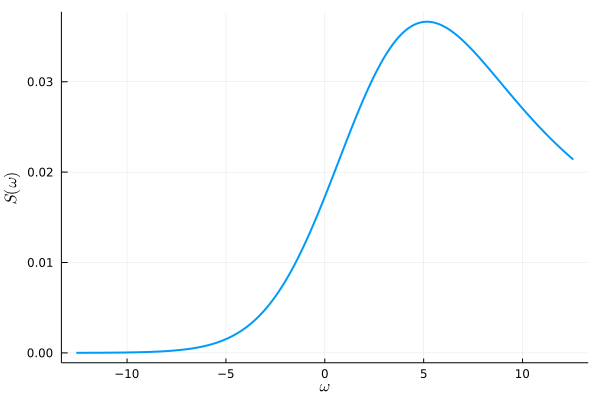

In [51]:
# The unit of the MRT linewidth is mK
W=10; η=1e-2; fc=2*π*4; T=12
Sₖ = build_polaron_high_freq_1f_spectrum(W, η, fc, T, Sf)
ω_list = 2 * π * range(-2, 2, length=200)
y = [Sₖ(w) for w in ω_list]
plot(ω_list, y, linewidth=2, xlabel=L"\omega", label="", ylabel=L"S(\omega)")

After we build the new polaron frame spectrum $\gamma_K(\omega)$, we can follow the same procedure in the previous section to solve the Lindblad form of PTRE.

In [53]:
sfun = construct_interpolations(ω_list, y)
bath = CustomBath(spectrum=sfun)
anneal = Annealing(H, u0, coupling=coupling, bath=bath)

Annealing with DenseHamiltonian{ComplexF64} and u0 Vector{ComplexF64}
u0 size: (2,)

In [54]:
tf_list = range(10, 200, length=200)
res = []
for tf in tf_list
    sol = solve_ame(anneal, tf, lambshift=false, alg=Tsit5(), reltol=1e-6, abstol=1e-6, save_everystep=false)
    push!(res, real(sol[end][1,1]))
end

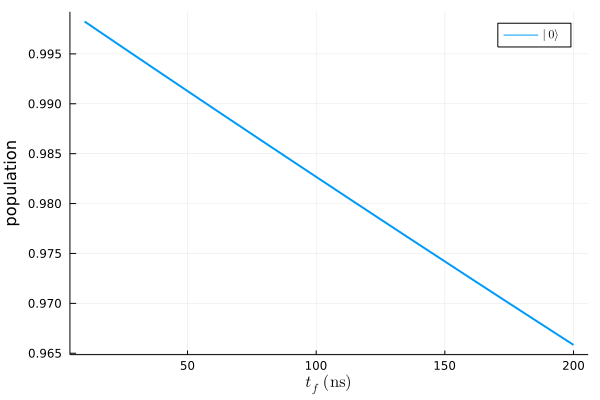

In [55]:
plot(tf_list, res, linewidth=2, xlabel=L"t_f \ (\mathrm{ns})", ylabel="population", label=L"|0\rangle")